# Truncated Svd on amzon fine food review

# Objective :-

1. Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.

2. You need to calculate the co-occurrence matrix with the selected features (Note: X.X^Tdoesn’t give the co-occurrence matrix, it returns the covariance matrix, check these bolgs blog1, blog2 for more information).

3. You should choose the n_components in truncated svd, with maximum explainedvariance. Please search on how to choose that and implement them. (hint: plot of cumulative explained variance ratio).

4. After you are done with the truncated svd, you can apply K-Means clustering and choosethe best number of clusters based on elbow method.

5. You need to write a function that takes a word and returns the most similar words usingcosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)

In [91]:
import os
os.getcwd()

'C:\\Users\\Nicky\\Desktop\\my work\\truncatedsvd'

In [92]:
import numpy as np
import pandas as pd
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pickle
from sklearn.cluster import KMeans
import sqlite3 as sql
from collections import defaultdict

In [93]:
#Functions to save objects for later use and retireve it
def export(obj,filename):
    pickle.dump(obj,open(filename+".dmp","wb"))
def import1(filename):
    temp = pickle.load(open(filename+".dmp","rb"))
    return temp

In [94]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
food1 = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
food1.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,positive,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,b'june saw charm group rose begin droop pep ch...
1,150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [95]:
food1_sample=food1.sample(n=200000) #Taking random sample from hole dataset
food1_sample.sort_values('Time',inplace=True)
food1_sample.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
24,150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
456,451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
418,374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
332,374421,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...
441,374342,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...


# ---------------with 3000 top feaures------------------

# TFIDF

In [7]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec=TfidfVectorizer(max_features=3000,stop_words='english')
tfidf = tfidf_vec.fit_transform(food1_sample['CleanedText'].values)

Wall time: 4.74 s


In [8]:
top_fatures = tfidf_vec.get_feature_names()

In [9]:
top_fatures.index('buck')

324

# Co-occurance Matrix

The below code is found from the link given by the description .

https://datascience.stackexchange.com/questions/40038/how-to-implement-word-to-word-co-occurence-matrix-in-python

In [11]:
%%time
# code stub for occurence matrix sourced from here:
# Modified to create matrix to feed SVD

from nltk.tokenize import word_tokenize
from itertools import combinations
from collections import Counter

values = food1_sample['CleanedText'].values
reviews = [review.decode("utf-8") for review in values]

vocab = top_fatures 
review_list = [word_tokenize(review) for review in reviews]

co_occ = {ii:Counter({jj:0 for jj in vocab if jj!=ii}) for ii in vocab}
# k is the window length
k=5
for review in review_list:
    for ii in range(len(review)):
        if review[ii] in top_fatures:
            if ii < k:
                c = Counter(review[0:ii+k+1])
                del c[review[ii]]
                co_occ[review[ii]] = co_occ[review[ii]] + c

            elif ii > len(review)-(k+1):
                c = Counter(review[ii-k::])
                del c[review[ii]]
                co_occ[review[ii]] = co_occ[review[ii]] + c
            else:
                c = Counter(review[ii-k:ii+k+1])
                del c[review[ii]]
                co_occ[review[ii]] = co_occ[review[ii]] + c
co_occ = {ii:dict(co_occ[ii]) for ii in vocab}

Wall time: 1h 47min 42s


In [13]:
export(co_occ,"co_occ")
export(vocab,"vocab")

In [12]:
type(co_occ)

dict

In [14]:
co_occ=pd.DataFrame.from_dict(co_occ, orient='index', columns=co_occ.keys())

In [17]:
co_occ=co_occ.fillna(0.0)

In [18]:
co_occ.head(10)

,abil,abl,absolut,absorb,acai,accept,access,accid,accident,accompani,...,yum,yummi,zero,zevia,zico,zing,zip,ziploc,ziplock,zuke
abil,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abl,2.0,0.0,21.0,7.0,1.0,5.0,4.0,1.0,1.0,1.0,...,4.0,9.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
absolut,0.0,21.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,...,2.0,25.0,22.0,3.0,0.0,3.0,0.0,1.0,1.0,2.0
absorb,1.0,7.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acai,0.0,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accept,0.0,5.0,2.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
access,1.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accid,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accident,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accompani,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# n_components in truncated svd

In [19]:
from sklearn.decomposition import TruncatedSVD

In [20]:
svd = TruncatedSVD(n_components=2999, n_iter=10, random_state=42)
svd

TruncatedSVD(algorithm='randomized', n_components=2999, n_iter=10,
       random_state=42, tol=0.0)

In [22]:
%%time
ab=svd.fit(co_occ)

Wall time: 1min 13s


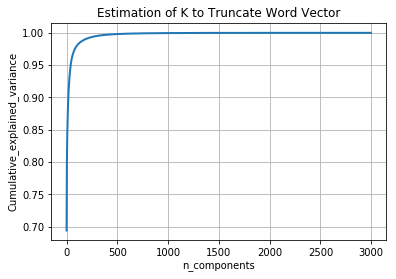

In [23]:
plt.figure(1, figsize=(6, 4))
cum_var_explained=ab.explained_variance_ratio_.cumsum()
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.title('Estimation of K to Truncate Word Vector')
plt.show()

# Word vector using truncated SVD :-

In [24]:
%%time
#From the above explanied_variance vs componet plot we can able to see with n=600 more than 95% of variance is explained
svd = TruncatedSVD(n_components=600, n_iter=10, random_state=42)
word_vec=svd.fit_transform(co_occ)

Wall time: 9.07 s


In [25]:
word_vec

array([[ 6.64698644e+01, -3.41299675e+00,  8.41231753e+00, ...,
         1.41854691e+00,  1.78240174e-01,  8.09329788e-01],
       [ 1.09068754e+03,  9.48582185e+00,  4.43689084e+02, ...,
         1.06112047e+00, -2.96823433e+00,  5.35398674e+00],
       [ 1.18883725e+03, -5.83791900e+01,  1.31733323e+02, ...,
         2.54616477e+00, -1.65304425e+00, -3.45958806e+00],
       ...,
       [ 3.20168768e+01,  5.35216660e+00,  1.60955485e+01, ...,
        -1.68253052e+00,  6.61506619e-01,  1.56344730e+00],
       [ 3.95046358e+01,  1.70942196e+00,  1.91355990e+01, ...,
        -3.00050747e+00,  2.99938529e+00,  9.23780581e-01],
       [ 4.27690967e+01,  9.03033803e+00,  2.16913247e+01, ...,
        -1.57792845e+00, -4.53387234e-01,  5.06861527e-01]])

# ---------------------------------K-Means Clustering--------------------------------------------------

# Elbow method for finding Best clusters K

In [26]:
# To find K of K-means using elbow method.
# This fn plots the loss vs k graph to find the elbow point
kcluster=[int(i) for i in range(2,50)]
def findbestK(vecotor):
    out = {}
    for k in kcluster:
        kalogo = KMeans(n_clusters=k,n_jobs=-1,n_init=10)
        kalogo.fit(vecotor)
        # Inertia: Sum of distances of samples to their closest cluster center
        out[k] = kalogo.inertia_
    #print(out)
    plt.figure()
    plt.plot(list(out.keys()), list(out.values()),'bx-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Loss Value")
    plt.title('The optimal k value using Elbow methd')
    plt.grid()
    plt.show()

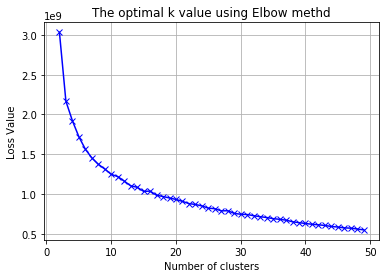

Wall time: 7min 29s


In [27]:
%%time
findbestK(word_vec)

Fom the above elbow plot we can able to see after 15 there is sudden change in the loss , so i am taking k as 20 for cluster.

In [28]:
%%time
kmeans_alogo = KMeans(n_clusters=20,max_iter=300, random_state=5).fit(word_vec)

Wall time: 2.95 s


In [29]:
kmeans_alogo.labels_

array([4, 7, 7, ..., 4, 4, 4])

In [50]:
labels = kmeans_alogo.labels_
word2vec = pd.DataFrame(word_vec)
word2vec['word'] = co_occ.index.values
word2vec['clusters'] = labels

In [52]:
from wordcloud import WordCloud
def print_cluster(cluster_number):
    cluster_data=word2vec[word2vec.clusters == cluster_number]
    cluster_corpus=" "
    for word in cluster_data.word.values:
        if word == word:
            word = word.lower()
            cluster_corpus += word
            cluster_corpus += ' '
    wordcloud1 = WordCloud(max_font_size=40).generate(cluster_corpus)
    plt.figure()
    plt.imshow(wordcloud1, interpolation="bilinear")
    plt.axis("off")
    plt.title('Cluster {} Words'.format(cluster_number))
    plt.show()

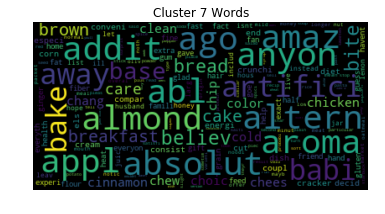

In [55]:
print_cluster(7)

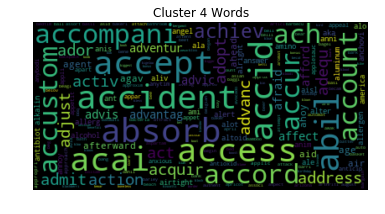

In [53]:
print_cluster(4)

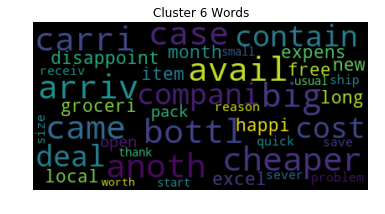

In [65]:
print_cluster(6)

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

In [67]:
word2vec.drop('clusters', inplace=True, axis=1)

word2vec.set_index('word', inplace=True)

del word2vec.index.name

In [87]:
def most_similar(word2vec, word, number_of_word):
    try:
        word_vector = word2vec.loc[word]
    except:
        raise KeyError('word not found')
    word2vec = word2vec[word2vec.index != word]
    dm = np.array(word2vec)
    word_vector = np.array(word_vector).reshape(1, -1)
    cs = cosine_similarity(word_vector, word2vec)
    top_n_index = np.argsort(cs)[0][::-1][0:number_of_word]
    scores = np.sort(cs)[0][::-1][0:number_of_word]
    top_words = word2vec.index[top_n_index]
    return dict(zip(top_words, scores))

In [85]:
most_similar(word2vec,'juic',10)

{'pure': 0.7955719375344241,
 'soda': 0.7878967766940149,
 'pineappl': 0.7782739954142317,
 'lemonad': 0.773423936819843,
 'beverag': 0.7703501023129699,
 'fizz': 0.7683187954346457,
 'carbon': 0.7644667652752136,
 'ad': 0.7642156370056981,
 'tropic': 0.7596117286705477,
 'punch': 0.7522839711405019}

In [88]:
most_similar(word2vec,'indian',10)

{'thai': 0.7898817395320369,
 'mexican': 0.7810837212338485,
 'authent': 0.7665426170470016,
 'babi': 0.7634829443037642,
 'cuisin': 0.7565665217422127,
 'asian': 0.7518782326907993,
 'comfort': 0.7513063687574002,
 'dri': 0.7477821489805793,
 'junk': 0.7442139116605553,
 'chef': 0.7432877900812365}

In [89]:
most_similar(word2vec,'pasta',10)

{'spaghetti': 0.844488927988295,
 'noodl': 0.8313134393887667,
 'cook': 0.7926249031840076,
 'soup': 0.7921715659361707,
 'meat': 0.7908477498829355,
 'dish': 0.7884261830112682,
 'everyth': 0.7878096253986768,
 'couscous': 0.787260333156332,
 'thing': 0.7868292526861861,
 'whatev': 0.7805562705444665}

In [90]:
most_similar(word2vec,'chicken',10)

{'meat': 0.8965006768707922,
 'gravi': 0.8508386419708796,
 'dish': 0.8368357523804922,
 'seafood': 0.8345249936153162,
 'fish': 0.8251548181940881,
 'veggi': 0.8240800200722164,
 'hamburg': 0.8174443584882902,
 'veget': 0.813363957676029,
 'steak': 0.8102200778417676,
 'cook': 0.8065754096310274}

# -----With 5000 top features ----------

In [96]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec=TfidfVectorizer(max_features=5000,stop_words='english')
tfidf = tfidf_vec.fit_transform(food1_sample['CleanedText'].values)

Wall time: 9.5 s


In [97]:
top_fatures = tfidf_vec.get_feature_names()

In [98]:
top_fatures.index('coff')

860

In [99]:
%%time
# code stub for occurence matrix sourced from here:
# Modified to create matrix to feed SVD

from nltk.tokenize import word_tokenize
from itertools import combinations
from collections import Counter

values = food1_sample['CleanedText'].values
reviews = [review.decode("utf-8") for review in values]

vocab = top_fatures 
review_list = [word_tokenize(review) for review in reviews]

co_occ = {ii:Counter({jj:0 for jj in vocab if jj!=ii}) for ii in vocab}
# k is the window length
k=5
for review in review_list:
    for ii in range(len(review)):
        if review[ii] in top_fatures:
            if ii < k:
                c = Counter(review[0:ii+k+1])
                del c[review[ii]]
                co_occ[review[ii]] = co_occ[review[ii]] + c

            elif ii > len(review)-(k+1):
                c = Counter(review[ii-k::])
                del c[review[ii]]
                co_occ[review[ii]] = co_occ[review[ii]] + c
            else:
                c = Counter(review[ii-k:ii+k+1])
                del c[review[ii]]
                co_occ[review[ii]] = co_occ[review[ii]] + c
co_occ = {ii:dict(co_occ[ii]) for ii in vocab}

Wall time: 5h 3min 38s


In [100]:
co_occ=pd.DataFrame.from_dict(co_occ, orient='index', columns=co_occ.keys())

In [101]:
co_occ=co_occ.fillna(0.0)

In [102]:
co_occ.head(5)

,abandon,abil,abl,absolut,absorb,absurd,abund,abus,acai,accent,...,zing,zinger,zip,ziploc,ziplock,zipper,zoe,zone,zucchini,zuke
abandon,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abil,0.0,0.0,3.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
abl,0.0,3.0,0.0,39.0,7.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
absolut,2.0,1.0,39.0,0.0,4.0,2.0,0.0,0.0,4.0,0.0,...,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0
absorb,0.0,5.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
%%time
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=4999, n_iter=10, random_state=42)
ab=svd.fit(co_occ)

Wall time: 6min 53s


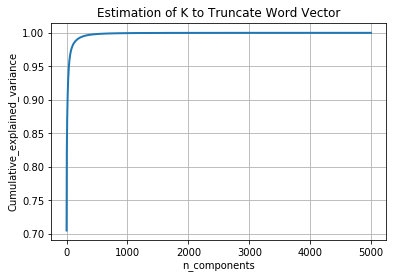

In [104]:
plt.figure(1, figsize=(6, 4))
cum_var_explained=ab.explained_variance_ratio_.cumsum()
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.title('Estimation of K to Truncate Word Vector')
plt.show()

In [105]:
%%time
#From the above explanied_variance vs componet plot we can able to see with n=1000 more than 95% of variance is explained
svd = TruncatedSVD(n_components=1000, n_iter=10, random_state=42)
word_vec=svd.fit_transform(co_occ)

Wall time: 46.8 s


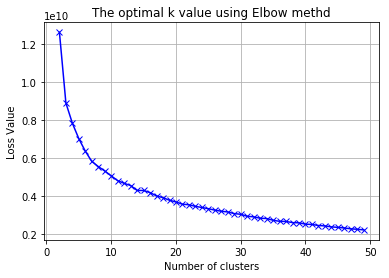

Wall time: 17min 39s


In [106]:
%%time
findbestK(word_vec)

In [108]:
%%time
kmeans_alogo = KMeans(n_clusters=20,max_iter=300, random_state=5).fit(word_vec)

Wall time: 8.99 s


In [109]:
labels = kmeans_alogo.labels_
word2vec = pd.DataFrame(word_vec)
word2vec['word'] = co_occ.index.values
word2vec['clusters'] = labels

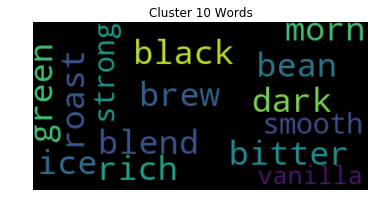

In [113]:
print_cluster(10)

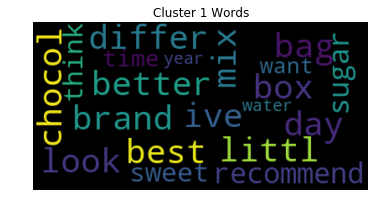

In [119]:
print_cluster(1)

In [120]:
word2vec.drop('clusters', inplace=True, axis=1)

word2vec.set_index('word', inplace=True)

del word2vec.index.name

In [121]:
most_similar(word2vec,'juic',10)

{'pure': 0.7939952066993057,
 'soda': 0.785644347833057,
 'beverag': 0.7803733656329437,
 'ad': 0.767980213324359,
 'fizz': 0.7665289064542976,
 'fizzi': 0.7626293787269176,
 'lemonad': 0.7607227057201059,
 'pineappl': 0.7526734997928769,
 'carbon': 0.7489357153336638,
 'tropic': 0.7480417627018932}

In [122]:
most_similar(word2vec,'pasta',10)

{'spaghetti': 0.850507669100348,
 'noodl': 0.8252929395518236,
 'couscous': 0.812433644745578,
 'soup': 0.7905847953529738,
 'everyth': 0.7898927911196844,
 'thing': 0.7837589124046405,
 'ketchup': 0.7822147801139221,
 'alot': 0.7793577945221175,
 'cook': 0.7792248445677351,
 'cours': 0.7765325755542641}

In [123]:
most_similar(word2vec,'mexican',10)

{'indian': 0.8164279035905014,
 'condiment': 0.7977642237815987,
 'spici': 0.7858122457275514,
 'chili': 0.7773540943518816,
 'salsa': 0.7689808223150023,
 'dish': 0.7490987221771316,
 'everyth': 0.7461384630646584,
 'mustard': 0.7431504945089611,
 'gourmet': 0.7422407729735173,
 'versatil': 0.7407847814003674}

# Conclusion :--

1). Here we are able observe that similar ralationship words are cluster .

2). Truncatedsvd on co-occrunace matix semantically related words are cluster together .

3). By factor decompostion we are able to find the similar word very easily .